In [1]:
# platform
from EphysDataHelper.datautils import *
from EphysDataHelper.plotutils import *
from EphysDataHelper.simutils import *
from EphysDataHelper.evalutils import *

import numpy as np
import torch
import pandas as pd

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
    
# SBI
import sbi.utils as utils
from sbi.inference import SNPE, prepare_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from sbi.utils import pairplot, conditional_pairplot, conditional_corrcoeff, eval_conditional_density

# parallel processing
#from joblib import Parallel, delayed
#from tqdm.auto import tqdm

# warning handlings
#import warnings

In [2]:
# remove top and right axis from plot
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

average tau = 0.006 s
R_input = 140.881MOhm


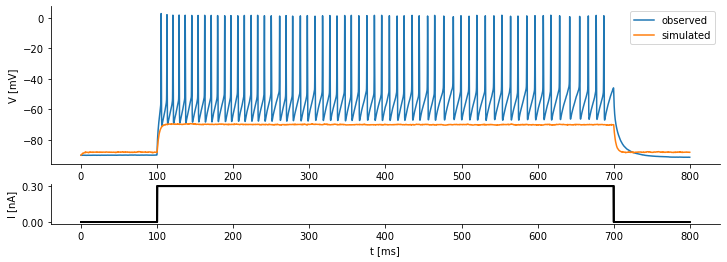

In [3]:
# parameters
cell_params = {"Description": "TestCell", "C": 1e-2, "Type": "Pvalb Calb1_1"}
exp_params = {"StimDur": 0.6, "StimOnset": 0.1, 
              "StimEnd": 0.7, "ObsTime" :1., 
              "IStep": 20*1e-12, "LiqJuncPotential": 15.4*1e-3,
              "Description": "20200403_sample_4"}

# file location
observations = '../data/04_03_2020_sample_4.mat'

# selecting and fitting experimental data
ExpData = Data(observations, exp_params=exp_params, cell_params=cell_params)
ExpData.select_subset([2],t_cutoff=0.8)
ExpData.fitcell2observations(show=False)
ExpData.set_syn_current(141*1e6,6*1e-3)

# selecting observation and HH parameters
trace_obs = ExpData.Observations_selected[25]
param_guess = {r'$g_{Na}$': 9.0191374e+00, r'$g_{K}$': 1.7598242e+01,
                r'$g_{M}$': 3.7206849e-01, r'$g_{leak}$': 3.8078189e-01,
                r'$\tau_{max}$': 9.8968518e+02, r'$V_{T}$': -6.3518044e+01,
                r'$E_{leak}$': -8.8042015e+01, 'time constant factor': 0.6}

param_vec = np.array(list(param_guess.values())).reshape(1,-1)

# simulating trace
trace_sim = runHH(param_vec, trace=trace_obs)
axs = trace_obs.inspect(label="observed")
trace_sim.inspect(label="simulated", axes=axs)
plt.show()

In [4]:
# specifying prior and sampling parameters
prior_min = [.5, 1e-4, 1e-4, 1e-4, 50, -90, -100, 0.1]
prior_max = [80., 30, 0.6, 0.6, 3000, -40, -35, 3]
prior = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), 
                                    high=torch.as_tensor(prior_max))

# run simulations from the prior samples and collect the results
theta = prior.sample((2000,))

In [5]:
n_threads = 2
batchsize = 25

simulated_traces = simulate_batches(theta, trace_obs=trace_obs, num_workers=n_threads, 
                                    using="C++", batch_size=batchsize)


Simulating 100 samples in Brian2 took 13.3s -> 0.133s per simulated trace
Simulating 100 samples in C++ took 0.9s -> 0.009s per simulated trace
Simulating 100 samples in python took 164.3s -> 1.643s per simulated trace


In [5]:

summaries = summarise_batches(simulated_traces) #num of workers > 1 works only if Trace is imported from Module

stats_obs = pd.DataFrame([pd.Series(trace_obs.summarise())])
stats_sim = pd.DataFrame(np.array(summaries), columns=stats_obs.columns)
params_sim = pd.DataFrame(np.array(theta), columns=param_guess.keys())
sim_results_df = pd.concat([params_sim, stats_sim], axis=1)

In [6]:
PATH = "../data/saved_stats/{0}_{1}paramprior_stats_Iscale1.csv".format(ExpData.Description, len(params_sim.columns))

# export stats to csv
sim_results_df.to_csv(PATH, index=False)

In [8]:
# import stats from csv
PATH = "../data//saved_stats/{0}_{1}paramprior_stats_Iscale1.csv".format(ExpData.Description, len(params_sim.columns))

sim_results_df = pd.read_csv(PATH)
sim_results_df.head()

n_params = 8
params_sim, stats_sim = sim_results_df.iloc[:,:n_params], sim_results_df.iloc[:,n_params:]
stats_sim.head()

In [9]:
# import
theta = np.load('../data/saved_stats/{}_8paramprior_stats_Iscale1.npz'.format(ExpData.Description))['theta']
stats = np.load('../data/saved_stats/{}_8paramprior_stats_Iscale1.npz'.format(ExpData.Description))['stats']
theta = theta[:stats.shape[0],:] # why !?

stats_obs = pd.DataFrame([pd.Series(trace_obs.summarise())])
params_sim = pd.DataFrame(data=theta, columns=list(param_guess.keys())) 
stats_sim = pd.DataFrame(data=stats, columns=stats_obs.columns)

In [1]:
# check coverage
# plot_summary_stats(stats_sim, stats_obs)

In [12]:
# select covered summary stats
selected_indices = [0,1,2,3,5,6,7,8,10,11,12,14,15,18,19,20,21,23,24,25]
selected_metrics = stats_sim.columns[selected_indices]
na_idx = stats_sim.T.isna().any()
#stats_sim.columns[[4,9,13,16,17,22]]

stats_obs_selected = stats_obs[selected_metrics]
stats_sim_selected = stats_sim[selected_metrics].loc[~na_idx]
thetas_selected = params_sim.loc[~na_idx]
#traces_selected = np.array(results)[~na_idx]

stats_sim_selected_norm = normalise_df(stats_sim_selected)
#stats_obs_selected_norm = normalise(stats_obs_selected)

In [38]:
#plot_best_matches(traces_selected,trace_obs)

## Inference

In [19]:
prior_min = [.5, 1e-4, 1e-4, 1e-4, 50, -90, -100, 0.1]
prior_max = [80., 30, 0.6, 0.6, 3000, -40, -35, 3]
prior = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), 
                                    high=torch.as_tensor(prior_max))

simulate_obs_trace = lambda params: simulate_and_summarise(params, trace=trace_obs, 
                                                           selected_stats=selected_indices)

simulator, prior = prepare_for_sbi(simulate_obs_trace, prior)

density_estimator_build_fun = posterior_nn(model='mdn') # Here you could change your model e.g. to 'maf' or 'nsf' 

In [20]:
inference = SNPE(prior, density_estimator=density_estimator_build_fun, 
                 show_progress_bars=True) # num_workers is not supported anymore

density_estimator = inference.append_simulations(torch.as_tensor(thetas_selected.values, dtype=torch.float32), \
                               torch.as_tensor(stats_sim_selected.values, dtype=torch.float32)).train()

posterior = inference.build_posterior(density_estimator)  # MCMC kwargs go here.

In [21]:
#torch.save(posterior, "./trained_posteriors/nsf_posterior_"+ ExpData.Description)
#posterior = torch.load("./trained_posteriors/maf_posterior_"+ ExpData.Description)

In [2]:
samples = posterior.sample((20000,), x=stats_obs_selected.values)

In [ ]:
fig, axes = utils.pairplot(samples,
                           limits=list(zip(prior_min,prior_max)),
                           ticks=list(zip(prior_min,prior_max)),
                           #points=closest_samples[[d_max_idxs]],
                           fig_size=(14,14),
                           labels=list(param_guess.keys()),
                           points_offdiag={'markersize': 6},
                           points_colors='r');
#plt.savefig('./figures/{}/posterior_distribution_Iscale1.png'.format(cell_name))

In [ ]:
posterior.set_default_x(stats_obs_selected.values)

corr_matrix_marginal = np.corrcoef(samples.T)
fig, ax = plt.subplots(1,1, figsize=(4, 4))
im = plt.imshow(corr_matrix_marginal, clim=[-1, 1], cmap='PiYG')
_ = fig.colorbar(im)

In [ ]:
posterior.set_default_x(stats_obs_selected.values)
most_probable_samples = np.array(np.argsort(posterior.log_prob(samples)))[::-1]
idx_p_max = most_probable_samples[0]
print("highest posterior probability by index", most_probable_samples)

In [ ]:
plot_comparison(runHH(samples[idx_p_max],trace_obs), trace_obs, figsize=(20,10))

In [ ]:
output_traces = []
num_sims = 2000
for i in range(num_sims):
    print("\rRunning Simulation {}/{}".format(i+1,num_sims), end=" ")
    trace_out = runHH(np.array(samples[i,:]),trace_obs)
    output_traces.append(trace_out)

## Conditional Posterior

In [ ]:
#condition = samples[min_MSE_idx[0]]#.reshape([1,8]) # WATCH OUT !!! CRUCIAL FOR THE COND CORR TO WORK
condition = samples[idx_p_max]
condition = posterior.sample((1,))
print("p =", float(np.exp(posterior.log_prob(condition))))

In [ ]:
_ = conditional_pairplot(
    density=posterior,
    condition=condition,
    #points=closest_samples[[d_max_idxs]],
    limits=list(zip(prior_min,prior_max)),
    ticks=list(zip(prior_min,prior_max)),
    fig_size=(14,14),
    points_offdiag={'markersize': 6},
    points_colors='r',
    labels=list(param_guess.keys()),
)

In [ ]:
cond_coeff_mat = conditional_corrcoeff(density=posterior,
                                       condition=condition,
                                       limits=torch.Tensor(list(zip(prior_min,prior_max))))
fig, ax = plt.subplots(1,1, figsize=(4,4))
im = plt.imshow(cond_coeff_mat, clim=[-1, 1], cmap='PiYG')
_ = fig.colorbar(im)

In [ ]:
#plot_correlation_effects(condition, trace_obs.get_syn_current(), cond_coeff_mat, mag_of_change=0.1, figsize=(15,10), timewindow=[0.3,0.35], effect_on="summary_stats", selected_stats=selected_indices)
#plot_correlation_effects(condition, trace_obs.get_syn_current(), cond_coeff_mat, mag_of_change=0.1, figsize=(15,10), timewindow=[0.3,0.35], effect_on="traces")
show_correlated_traces(condition, trace_obs.get_syn_current(), cond_coeff_mat, pair=(1,5))

In [ ]:
#plot_correlated_summary_stats(condition, trace_obs.get_syn_current(), cond_coeff_mat, selected_stats=selected_indices, pair=(1,4))
#show_correlated_traces(condition, trace_obs.get_syn_current(), cond_coeff_mat, pair=(2,6))